In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Stomach Cancer Diagnosis by Graph Neural Networks
# ##  PyTorch Implementation for GCN + TopKPooling with LeNet5 Architecture 
# ### Wang, Y. G. @UNSW, Dec 2019
# ### Yanan Wang @Monash

# ## Main Program


# In[ ]:

# import os
import time
from matplotlib import pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.metrics import confusion_matrix
import matplotlib
import argparse
from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# from torch.utils.data import random_split
# from torch_geometric.data import InMemoryDataset
# import matplotlib.pyplot as plt
# import pandas as pd

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_multi_label_confusion_matrix(_save_path, y_true, y_pred, labels, normalize=False, title=None, cmap=plt.cm.Blues):
    plt.close('all')
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 8})
    plt.rcParams.update({'font.family':'Arial'})
    conf_mat_dict={}

    class_num = len(labels)

    plot_rows = int(class_num/4)+1
    plot_cols = 4 if class_num>=4 else class_num

    for label_col in range(class_num):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]

        print(y_true_label)
        print(y_pred_label)
        conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


    fig, axes = plt.subplots(nrows=plot_rows, ncols=plot_cols, sharex=False, sharey=False,gridspec_kw = {'wspace':0.5, 'hspace':0.05},figsize=(10,10))
    axes = trim_axs(axes, class_num)
    for ii in range(len(labels)):
        _label = labels[ii]
        _matrix = conf_mat_dict[_label]
        axes[ii].imshow(_matrix,interpolation='nearest', cmap=plt.cm.Blues)
        axes[ii].set(xticks=np.arange(_matrix.shape[1]),
               yticks=np.arange(_matrix.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"],
               title=_label,
               ylabel='True label',
               xlabel='Predicted label')
        fmt = 'd'
        thresh = _matrix.max() / 2.
        for i in range(_matrix.shape[0]):
            for j in range(_matrix.shape[1]):
                axes[ii].text(j, i, format(_matrix[i, j], fmt),
                    ha="center", va="center", fontsize=8,
                    color="white" if _matrix[i, j] > thresh else "black")

    plt.savefig(_save_path, dpi=100,pad_inches = 0.1,bbox_inches = 'tight')


# In[ ]:

def calculate_metrics(gts, ops, preds, class_num, labels, outputs, mode):
    if mode:
        gts = np.vstack([gts, labels.cpu()]) if gts.size else labels.cpu()
        y_pred = outputs.unsqueeze(1)
        y_pred = torch.cat([1.0 - y_pred, y_pred], dim=1)
        y_pred = torch.max(y_pred, dim=1)[1]
        # print("Predict is %s"%y_pred)
        preds = np.vstack([preds, y_pred.cpu()]) if preds.size else y_pred.cpu()
    else:
        _labels = labels.cpu()
        tmp = torch.zeros(len(_labels), class_num)
        for idx, ele in enumerate(_labels):
            tmp[idx][ele] = 1
        gts = np.vstack([gts, tmp]) if gts.size else tmp
        view = outputs.view(-1, class_num)
        y_pred = (view == view.max(dim=1, keepdim=True)[0]).view_as(outputs).type(torch.ByteTensor)
            # y_pred = torch.max(outputs, 1)[1].view(labels.size())
            # y_pred = np.argmax(y_pred.cpu())
            # print(y_pred)
        preds = np.vstack([preds, y_pred.cpu()]) if preds.size else y_pred.cpu()

    acc_list = []
    auc_list = []
    f1 = f1_score(gts, preds, average="micro")
    for j in range(0, class_num):
        gts_i = gts[:,j]
        preds_i = preds[:,j]
        ops_i = ops[:,j]
        fpr, tpr, thresholds = roc_curve(gts_i, ops_i)
        acc_score = accuracy_score(gts_i, preds_i)
        auc_score = auc(fpr, tpr)
        acc_list.append(acc_score)
        auc_list.append(auc_score)
        print("class_num: %d, acc_score: %f, auc_score: %f"%(j, acc_score, auc_score))
    return acc_list, auc_list, f1, gts, ops, preds


def plot_confusion_matrix(_model, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    plot_multi_label_confusion_matrix('/home/yuguang/cellstar/figures/%s_Confusion_matrix.png' % _model, y_true, y_pred, classes)

    
def plot_roc_curve(pred_y, test_y, class_label, n_classes, fig_name="roc_auc.png"):
    #pred_y = pred_y/pred_y.max(axis=0)
    colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000", "#66CC99", "#999999"]
    plt.close('all')
    plt.style.use("ggplot")
    matplotlib.rcParams['font.family'] = "Arial"
    plt.figure(figsize=(8, 8), dpi=400)
    for i in range(n_classes):
        _tmp_pred = pred_y
        _tmp_label = test_y
        #print(_tmp_label[:, 0], _tmp_pred[:, 0])
        _fpr, _tpr, _ = roc_curve(_tmp_label[:, i], _tmp_pred[:, i])
        _auc = auc(_fpr, _tpr)
        plt.plot(_fpr, _tpr, color=colors[i],
                 label=r'%s ROC (AUC = %0.3f)' % (class_label[i], _auc), lw=2, alpha=.9)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC curve of')
    plt.legend(loc="lower right")
    plt.savefig(fig_name, dpi=400)
    plt.close('all')

##Define Model Class
class GCNTopK(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid=256, pooling_ratio=0.75):
        super(GCNTopK, self).__init__()
        self.nhid = nhid
        self.pooling_ratio = pooling_ratio
        self.conv1 = GraphConv(int(num_feature), self.nhid)
        self.pool1 = TopKPooling(self.nhid, ratio = self.pooling_ratio) # edited by Ming with concern for further extension
        self.conv2 = GraphConv(self.nhid, self.nhid)
        self.pool2 = TopKPooling(self.nhid, ratio = self.pooling_ratio)
        self.conv3 = GraphConv(self.nhid, self.nhid)
        self.pool3 = TopKPooling(self.nhid, ratio = self.pooling_ratio)
        #add one more conv-pooling block, i.e., conv4 and pool4
        self.conv4 = GraphConv(self.nhid, self.nhid)
        self.pool4 = TopKPooling(self.nhid, ratio = self.pooling_ratio)

        self.lin1 = torch.nn.Linear(self.nhid*2, self.nhid)   # edited by Ming with concern for further extension
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid//2)
        self.lin3 = torch.nn.Linear(self.nhid//2, num_class)  # edited by Ming with concern for further extension

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool3(x, edge_index, edge_attr, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        #add one more conv-pooling block, corresponding to conv4 and pool4
        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool4(x, edge_index, edge_attr, batch)
        x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4
#         x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
#         print('shape of x before log_softmax: ',x.shape)
        y1 = F.log_softmax(self.lin3(x), dim=-1)
#         print('shape of x after log_softmax: ',x.shape)
        y2 = torch.sigmoid(self.lin3(x))

        return y1, y2
    
##GINTopK
class GINTopK(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid):
        super(GINTopK, self).__init__()
        self.conv1 = GINConv(Seq(Lin(num_feature, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool1 = TopKPooling(nhid, ratio=0.8)
        self.conv2 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool2 = TopKPooling(nhid, ratio=0.8)
        self.conv3 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool3 = TopKPooling(nhid, ratio=0.8)
        self.conv4 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool4 = TopKPooling(nhid, ratio=0.8)

        self.lin1 = torch.nn.Linear(2*nhid, nhid)
        self.lin2 = torch.nn.Linear(nhid, nhid//2)
        self.lin3 = torch.nn.Linear(nhid//2, num_class)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        
        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
        x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        y1 = F.log_softmax(self.lin3(x), dim=-1)
        y2 = torch.sigmoid(self.lin3(x))

        return y1, y2

def train(model,train_loader,device):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_loader.dataset)
      
def test(model,loader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0.
    loss = 0.   # edited by Ming with concern for further extension
    pred_1 = list()
    out_1 = np.array([])
    gt_l = np.array([])
    pred_bi = np.array([])
    label = np.array([])
    for data in loader:
        data = data.to(device)
        out, out2 = model(data)
#         print('out, out2 in test: ',out,out2)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        loss += F.nll_loss(out, data.y,reduction='sum').item()
        
        pred_1.append(pred.cpu().detach().numpy())
        out_1 = np.vstack([out_1, out2.cpu().detach().numpy()]) if out_1.size else out2.cpu().detach().numpy()
        _tmp_label = data.y.cpu().detach().numpy()
        for _label in _tmp_label:
            if(_label == 0):
                _label_2d = np.array([1, 0])
            elif(_label == 1):
                _label_2d = np.array([0, 1])
            gt_l = np.vstack([gt_l, _label_2d]) if gt_l.size else _label_2d
        for _pred in pred:
            if(_pred == 0):
                _pred_bi = np.array([1, 0])
            if(_pred == 1):
                _pred_bi = np.array([0, 1])
            pred_bi = np.vstack([pred_bi,_pred_bi]) if pred_bi.size else _pred_bi
        label = np.hstack([label,_tmp_label]) if label.size else _tmp_label
    # pred_1 = np.array(pred_1).reshape(pred_1)
    return correct *1.0 / len(loader.dataset), loss / len(loader.dataset), pred_1, out_1, gt_l, label, pred_bi

In [2]:
# import argparse
#def hyperopt_train(batch_size=256, learning_rate=0.01, weight_decay=0.0005, nhid=256, pooling_ratio=0.75, epochs=200, runs=1):
         ## Parameter Setting
     #added by ming for future pooling extensions
    
# parser = argparse.ArgumentParser()
# parser.add_argument('--batch_size', type=int, default=256,
#                  help='batch size')
# parser.add_argument('--learning_rate', type=float, default=5e-4,
#                  help='learning rate')
# parser.add_argument('--weight_decay', type=float, default=1e-4,
#                  help='weight decay')
# parser.add_argument('--nhid', type=int, default=512,
#                  help='hidden size')
# parser.add_argument('--pooling_ratio', type=float, default=0.5,
#                  help='pooling ratio')
# parser.add_argument('--epochs', type=int, default=200,
#                  help='maximum number of epochs')
# # parser.add_argument('--early_stopping', type=int, default=100,
# #                  help='patience for earlystopping')
# parser.add_argument('--num_layers', type=int, default=4,
#                  help='number of layers')
# parser.add_argument('--runs', type=int, default=1,
#                  help='number of runs')
# args = parser.parse_args()

# batch_size = args.batch_size
# learning_rate = args.learning_rate
# weight_decay = args.weight_decay
# nhid = args.nhid
# pooling_ratio = args.pooling_ratio
# epochs = args.epochs
# # early_stopping = args.early_stopping
# num_layers = args.num_layers
# runs = args.runs

batch_size = 256
learning_rate = 5e-4
weight_decay = 1e-4
nhid = 512
pooling_ratio = 0.5
epochs = 200
# early_stopping = args.early_stopping
num_layers = 4
runs = 10
fold = 4

# early_stopping = epochs
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cuda


In [4]:
import os

def load_dataset(dataset_path):
    ## load and preprocess data for stomach cancer
    ld_edge_index = ""
    ld_edge_attr = ""
    ld_feature = ""
    ld_label = ""
    ld_pid = ""
    for _root, _dirs, _files in os.walk(dataset_path):
        for _file in _files:
            #print(_file)
            if("weighted_edge_index" in _file):
                ld_edge_index = os.path.join(_root, _file)
            elif("weighted_edge_attr" in _file):
                ld_edge_attr = os.path.join(_root, _file)
            elif("weighted_feature" in _file):
                ld_feature = os.path.join(_root, _file)
            elif("weighted_label" in _file):
                ld_label = os.path.join(_root, _file)
            elif("weighted_pid.mat" in _file):
                ld_pid = os.path.join(_root, _file)
#     print(ld_edge_index)
#     print(ld_edge_attr)
#     print(ld_feature)
#     print(ld_label)
#     print(ld_pid)

    edge_index = sio.loadmat(ld_edge_index)
    edge_index = edge_index['edge_index'][0]
    # load edge_attr
    edge_attr = sio.loadmat(ld_edge_attr)
    edge_attr = edge_attr['edge_attr'][0]
    # load feature
    feature = sio.loadmat(ld_feature)
    feature = feature['feature']
    #print(feature)
    # load label
    label = sio.loadmat(ld_label)
    label = label['label'][0]
    # load label_pid
    pid = sio.loadmat(ld_pid)
    pid = pid['pid'][0]
    
    stomach = list()
    num_edge = 0
    #num_feature = 0
    num_node = 0
    num_class = 2
    num_graph = edge_index.shape[0]

    for i in range(num_graph):
        # extract edge index, turn to tensor
        edge_index_1 = np.array(edge_index[i][:,0:2],dtype=np.int)
        edge_index_1 = torch.tensor(edge_index_1, dtype=torch.long).to(device)
        # number of edges
        num_edge = num_edge + edge_index_1.shape[0]
        # extract edge_attr, turn to tensor
        edge_attr_1 = np.array(edge_attr[i][:,0:1],dtype=np.int)
        edge_attr_1 = torch.tensor(edge_attr_1, dtype=torch.float).to(device)
        # extract feature, turn to tensor
        
        feature_1 = torch.tensor(feature[i], dtype=torch.float).to(device)
        #print(feature_1.shape)
        # number of nodes
        num_node = num_node + feature_1.shape[0]
        # number of features
        if i==0:
            num_feature = feature_1.shape[1]
        # extract label, turn to tensor
        label_1 = torch.tensor([label[i]-1],dtype=torch.long).to(device)
        # extract patient id, turn to tensor
        
        pid_1 = torch.tensor([pid[i]],dtype=torch.long).to(device)
        # put edge, feature, label together to form graph information in "Data" format
        data_1 = Data(x=feature_1, edge_index=edge_index_1.t().contiguous(), edge_attr=edge_attr_1, y=label_1, pid=pid_1)
        stomach.append(data_1)
    return(stomach, num_feature, num_edge, num_node)
        
train_data_list, num_feature, num_edge, num_node = load_dataset("data/selected_new_data_file/train_data_fold_{}/".format(fold))
val_data_list, _, _, _ = load_dataset("data/selected_new_data_file/val_data_fold_{}/".format(fold))
test_data_list, _, _, _ = load_dataset("data/selected_new_data_file/test_data/")

test_data_sur_list, _, _, _ = load_dataset("data/selected_new_data_file/test_data_surv/")

train_val_list = train_data_list + val_data_list
# generate training, validation and test data sets
nv = np.random.permutation(len(train_val_list))
stomach_1 = train_val_list
stomach = list()
for i in nv:
    stomach.append(stomach_1[nv[i]])
num_train_val = len(stomach)
num_train = int(num_train_val * 0.8)
#num_val = num_train_val - num_train

train_loader = DataLoader(stomach[0:num_train], batch_size=batch_size, shuffle = True)
val_loader = DataLoader(stomach[num_train:-1], batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_data_list, batch_size=1, shuffle = False)
test_surv_loader = DataLoader(test_data_sur_list, batch_size=1, shuffle = False)

In [23]:
# import EarlyStopping
from pytorchtools import EarlyStopping


sv_dat = 'gintopk/test_data.pt'
torch.save(test_data_list, sv_dat)
num_class = 2

print('**Data Set')
#print('Data name: {}, Data type: {},  #Graph: {}'.format('Stomach',data_type,num_graph))
print('Ave.#Edge: {:.1f}, Ave.#Feature: {:.1f}, Ave.#Node: {:.1f}, #Classes: {:d}'.format(num_edge,num_feature,num_node,num_class))
print('Train-val-test ratio: 7:1:2, Shuffle: True')
print('- number of training data:',len(train_loader))
print('- number of validation data:',len(val_loader))
print('- number of test data:',len(test_loader))

print('**Network Parameter Setting')
print('- batch size: ',batch_size)
print('- learning rate: ',learning_rate)
print('- weight decay: ',weight_decay)
print('- hidden size: ',nhid)
print('- pooling_ratio: ',pooling_ratio)
print('- maximum number of epochs: ',epochs)
# print('- patience for earlystopping: ',early_stopping)
print('- graph convolution: ','GCNConv')
print('- number of graph convoluational layers: {}x{}'.format(1,num_layers))
print('- graph pooling: ','TopKPooling')
print('- number of pooling layers: ',num_layers)
print('- number of fully connected layers: ',num_layers)
    
###############################################################

train_loss = np.zeros((runs,epochs),dtype=np.float)
val_acc = np.zeros((runs,epochs))
val_loss = np.zeros((runs,epochs))
test_acc_c = np.zeros(runs)
test_loss_c = np.zeros(runs)
test_pred_c = np.zeros(runs)
test_out_c = np.zeros((runs,num_class)) 
groud_truth_c = np.zeros((runs,num_class))
test_acc_p = np.zeros(runs)
min_loss = 1e10*np.ones(runs)
# num_test_p = num_test
# pid_test_p  = np.zeros((runs,num_test_p))
for run in range(runs):
#         print('\n*** Training ***')
#         print('** Run {} of total {} runs ...'.format(run+1,runs))
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GINTopK(num_feature=num_feature, num_class=num_class, nhid=nhid).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    
    ## Training

    # initialize the early_stopping object
    patience = 20
    early_stopping = EarlyStopping(patience=patience, verbose=True, path="gintopk/model_gintopk_fold{}_run{}.pth".format(fold, run))
#        val_acc_c = np.zeros((runs,epochs))
#        val_loss_c = np.zeros((runs,epochs))
#        test_acc_c = np.zeros(runs)
#        test_acc_p = np.zeros(runs)
    for epoch in range(epochs):
        model.train()
        loss_all = 0
        for i, data in enumerate(train_loader):
            data = data.to(device)
#             print('data in train: ',data)
            out, out2 = model(data)
            loss = F.nll_loss(out, data.y)
#             print(out, data.y)
            #writer.add_scalar('train/loss', loss, len(train_loader)*epoch+i)
            #print("Training loss: {:.5f}".format(loss.item()))
            loss.backward()
            loss_all += data.num_graphs * loss.item()
            optimizer.step()
            optimizer.zero_grad()
        loss = loss_all / len(train_loader.dataset)   
        train_loss[run,epoch] = loss
        val_acc[run,epoch], val_loss[run, epoch], _, _, _, _, _ = test(model, val_loader)
        print("Run: {:03d}, Epoch: {:03d}, Val loss: {:.5f}, Val acc: {:.5f}".format(run+1,epoch+1,val_loss[run,epoch],val_acc[run,epoch]))
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss[run, epoch], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
#         if val_loss[run,epoch] < min_loss[run]:
#             torch.save(model.state_dict(), 'model_gintopk.pth')   # save the model and reuse later in test
#             #print("Model saved at epoch: {:03d}".format(epoch))
#             min_loss[run] = val_loss[run,epoch]
    # model = GCNTopK(num_feature=num_feature, num_class=num_class, nhid=nhid, pooling_ratio=pooling_ratio).to(device)
    model = GINTopK(num_feature=num_feature, num_class=num_class, nhid=nhid).to(device)
    model.load_state_dict(torch.load("gintopk/model_gintopk_fold{}_run{}.pth".format(fold, run)))
    test_acc_c[run], test_loss_c[run], test_pred_c, test_out_c, ground_truth_c, test_label_c, test_pred_bi_c = test(model,test_loader)
    print("** Run: {:03d}, test loss: {:.5f}, test acc: {:.5f}".format(run+1,test_loss_c[run],test_acc_c[run]))
    pid_list = list()
    test_data = list([None] * len(test_loader))
    for i, data in enumerate(test_loader):
        pid_temp = data.pid.cpu().numpy()
        gt = data.y.cpu().numpy()
        test_data[i] = [pid_temp,gt,test_pred_c[i]]
        if not pid_temp in pid_list:
            pid_list.append(pid_temp)
    num_test_p = len(pid_list)
    test_pred_1 = np.zeros([num_class,num_test_p],dtype=np.int)
    pred_p = np.zeros(num_test_p,dtype=np.int)
    test_label_p = np.zeros(num_test_p,dtype=np.int)
    pid_test = np.array(pid_list)
    for j in range(num_test_p):
        pid_1 = pid_list[j]
        k = 0
        for i, data in enumerate(test_loader):
            if data.pid.cpu().numpy()==pid_1:
                if k==0:
                    test_label_p[j] = data.y.cpu().numpy()
                    k = 1
                test_pred_i = int(test_pred_c[i])
                test_pred_1[test_pred_i,j] = test_pred_1[test_pred_i,j] + 1
        pred_p[j] = np.argmax(test_pred_1[:,j])
  #   print('j: {}, pred_p[j]: {}, test_pred_p[j]: {}'.format(j,pred_p[j],test_label_p[j]))
    test_acc_p[run] = (pred_p==test_label_p).sum()*1.0/num_test_p
    print("Test accuarcy at patient level: {:.2f}".format(test_acc_p[run]*100))
    ## save data
    t1 = time.time()
    print("** Model {}, mean test acc (cell): {:.5f}".format(t1,np.mean(test_acc_c)))
    sv = 'gintopk/scdiag_gintopk' + '_fold' + str(fold) + '_runs' + str(runs) + '_run' + str(run) + '_epochs' + str(epochs)+'.mat'
    sio.savemat(sv,mdict={'val_loss':val_loss,'val_acc':val_acc,'test_loss_c':test_loss_c,'test_acc_c':test_acc_c,'train_loss':train_loss,'test_pred_c':test_pred_c,'test_out_c':test_out_c,'ground_truth_c':ground_truth_c,'test_label_c':test_label_c,'test_pred_bi_c':test_pred_bi_c,'test_acc_p':test_acc_p,'test_pred_p':pred_p,'pid_test':pid_test,'test_data':test_data})

**Data Set
Ave.#Edge: 4896328.0, Ave.#Feature: 35.0, Ave.#Node: 932900.0, #Classes: 2
Train-val-test ratio: 7:1:2, Shuffle: True
- number of training data: 37
- number of validation data: 10
- number of test data: 3143
**Network Parameter Setting
- batch size:  256
- learning rate:  0.0005
- weight decay:  0.0001
- hidden size:  512
- pooling_ratio:  0.5
- maximum number of epochs:  200
- graph convolution:  GCNConv
- number of graph convoluational layers: 1x4
- graph pooling:  TopKPooling
- number of pooling layers:  4
- number of fully connected layers:  4
Run: 001, Epoch: 001, Val loss: 0.66380, Val acc: 0.61192
Validation loss decreased (inf --> 0.663803).  Saving model ...
Run: 001, Epoch: 002, Val loss: 0.63805, Val acc: 0.62864
Validation loss decreased (0.663803 --> 0.638046).  Saving model ...
Run: 001, Epoch: 003, Val loss: 0.61755, Val acc: 0.65180
Validation loss decreased (0.638046 --> 0.617550).  Saving model ...
Run: 001, Epoch: 004, Val loss: 0.61446, Val acc: 0.63808
V

Run: 002, Epoch: 009, Val loss: 0.45511, Val acc: 0.77744
Validation loss decreased (0.471780 --> 0.455110).  Saving model ...
Run: 002, Epoch: 010, Val loss: 0.44809, Val acc: 0.77487
Validation loss decreased (0.455110 --> 0.448088).  Saving model ...
Run: 002, Epoch: 011, Val loss: 0.42819, Val acc: 0.79717
Validation loss decreased (0.448088 --> 0.428195).  Saving model ...
Run: 002, Epoch: 012, Val loss: 0.42406, Val acc: 0.79631
Validation loss decreased (0.428195 --> 0.424062).  Saving model ...
Run: 002, Epoch: 013, Val loss: 0.42406, Val acc: 0.80274
Validation loss decreased (0.424062 --> 0.424056).  Saving model ...
Run: 002, Epoch: 014, Val loss: 0.36107, Val acc: 0.83405
Validation loss decreased (0.424056 --> 0.361067).  Saving model ...
Run: 002, Epoch: 015, Val loss: 0.36318, Val acc: 0.82976
EarlyStopping counter: 1 out of 20
Run: 002, Epoch: 016, Val loss: 0.32074, Val acc: 0.85334
Validation loss decreased (0.361067 --> 0.320740).  Saving model ...
Run: 002, Epoch: 0

Run: 003, Epoch: 025, Val loss: 0.37340, Val acc: 0.85034
EarlyStopping counter: 1 out of 20
Run: 003, Epoch: 026, Val loss: 0.31296, Val acc: 0.86750
Validation loss decreased (0.322213 --> 0.312956).  Saving model ...
Run: 003, Epoch: 027, Val loss: 0.37962, Val acc: 0.85978
EarlyStopping counter: 1 out of 20
Run: 003, Epoch: 028, Val loss: 0.36119, Val acc: 0.84177
EarlyStopping counter: 2 out of 20
Run: 003, Epoch: 029, Val loss: 0.30228, Val acc: 0.88122
Validation loss decreased (0.312956 --> 0.302277).  Saving model ...
Run: 003, Epoch: 030, Val loss: 0.31675, Val acc: 0.88636
EarlyStopping counter: 1 out of 20
Run: 003, Epoch: 031, Val loss: 0.31070, Val acc: 0.87521
EarlyStopping counter: 2 out of 20
Run: 003, Epoch: 032, Val loss: 0.28410, Val acc: 0.87864
Validation loss decreased (0.302277 --> 0.284097).  Saving model ...
Run: 003, Epoch: 033, Val loss: 0.26818, Val acc: 0.90180
Validation loss decreased (0.284097 --> 0.268180).  Saving model ...
Run: 003, Epoch: 034, Val l

Run: 004, Epoch: 043, Val loss: 0.31734, Val acc: 0.86878
EarlyStopping counter: 1 out of 20
Run: 004, Epoch: 044, Val loss: 0.25324, Val acc: 0.90352
Validation loss decreased (0.270331 --> 0.253236).  Saving model ...
Run: 004, Epoch: 045, Val loss: 0.23635, Val acc: 0.91295
Validation loss decreased (0.253236 --> 0.236347).  Saving model ...
Run: 004, Epoch: 046, Val loss: 0.26531, Val acc: 0.90523
EarlyStopping counter: 1 out of 20
Run: 004, Epoch: 047, Val loss: 0.29572, Val acc: 0.89708
EarlyStopping counter: 2 out of 20
Run: 004, Epoch: 048, Val loss: 0.25086, Val acc: 0.90738
EarlyStopping counter: 3 out of 20
Run: 004, Epoch: 049, Val loss: 0.29017, Val acc: 0.88636
EarlyStopping counter: 4 out of 20
Run: 004, Epoch: 050, Val loss: 0.22236, Val acc: 0.91938
Validation loss decreased (0.236347 --> 0.222359).  Saving model ...
Run: 004, Epoch: 051, Val loss: 0.33101, Val acc: 0.89666
EarlyStopping counter: 1 out of 20
Run: 004, Epoch: 052, Val loss: 0.27870, Val acc: 0.89966
Ear

Run: 005, Epoch: 028, Val loss: 0.29319, Val acc: 0.87993
EarlyStopping counter: 3 out of 20
Run: 005, Epoch: 029, Val loss: 0.31088, Val acc: 0.88079
EarlyStopping counter: 4 out of 20
Run: 005, Epoch: 030, Val loss: 0.39284, Val acc: 0.82804
EarlyStopping counter: 5 out of 20
Run: 005, Epoch: 031, Val loss: 0.28320, Val acc: 0.88894
Validation loss decreased (0.287608 --> 0.283200).  Saving model ...
Run: 005, Epoch: 032, Val loss: 0.29290, Val acc: 0.89666
EarlyStopping counter: 1 out of 20
Run: 005, Epoch: 033, Val loss: 0.35500, Val acc: 0.88636
EarlyStopping counter: 2 out of 20
Run: 005, Epoch: 034, Val loss: 0.28880, Val acc: 0.89966
EarlyStopping counter: 3 out of 20
Run: 005, Epoch: 035, Val loss: 0.32219, Val acc: 0.90094
EarlyStopping counter: 4 out of 20
Run: 005, Epoch: 036, Val loss: 0.26293, Val acc: 0.90437
Validation loss decreased (0.283200 --> 0.262927).  Saving model ...
Run: 005, Epoch: 037, Val loss: 0.30011, Val acc: 0.89751
EarlyStopping counter: 1 out of 20
Ru

Run: 006, Epoch: 050, Val loss: 0.26543, Val acc: 0.90523
EarlyStopping counter: 1 out of 20
Run: 006, Epoch: 051, Val loss: 0.28580, Val acc: 0.89623
EarlyStopping counter: 2 out of 20
Run: 006, Epoch: 052, Val loss: 0.44056, Val acc: 0.86278
EarlyStopping counter: 3 out of 20
Run: 006, Epoch: 053, Val loss: 0.27598, Val acc: 0.90094
EarlyStopping counter: 4 out of 20
Run: 006, Epoch: 054, Val loss: 0.32083, Val acc: 0.89065
EarlyStopping counter: 5 out of 20
Run: 006, Epoch: 055, Val loss: 0.26046, Val acc: 0.90480
EarlyStopping counter: 6 out of 20
Run: 006, Epoch: 056, Val loss: 0.29233, Val acc: 0.90352
EarlyStopping counter: 7 out of 20
Run: 006, Epoch: 057, Val loss: 0.25740, Val acc: 0.90866
EarlyStopping counter: 8 out of 20
Run: 006, Epoch: 058, Val loss: 0.29840, Val acc: 0.90695
EarlyStopping counter: 9 out of 20
Run: 006, Epoch: 059, Val loss: 0.30352, Val acc: 0.90395
EarlyStopping counter: 10 out of 20
Run: 006, Epoch: 060, Val loss: 0.26216, Val acc: 0.91509
EarlyStoppi

Run: 007, Epoch: 059, Val loss: 0.27173, Val acc: 0.92153
EarlyStopping counter: 19 out of 20
Run: 007, Epoch: 060, Val loss: 0.30195, Val acc: 0.91381
EarlyStopping counter: 20 out of 20
Early stopping
** Run: 007, test loss: 0.34366, test acc: 0.90869
Test accuarcy at patient level: 93.55
** Model 1600400086.9086041, mean test acc (cell): 0.63859
Run: 008, Epoch: 001, Val loss: 0.66384, Val acc: 0.60249
Validation loss decreased (inf --> 0.663837).  Saving model ...
Run: 008, Epoch: 002, Val loss: 0.63538, Val acc: 0.63079
Validation loss decreased (0.663837 --> 0.635379).  Saving model ...
Run: 008, Epoch: 003, Val loss: 0.65910, Val acc: 0.60463
EarlyStopping counter: 1 out of 20
Run: 008, Epoch: 004, Val loss: 0.59799, Val acc: 0.67281
Validation loss decreased (0.635379 --> 0.597992).  Saving model ...
Run: 008, Epoch: 005, Val loss: 0.57864, Val acc: 0.68396
Validation loss decreased (0.597992 --> 0.578643).  Saving model ...
Run: 008, Epoch: 006, Val loss: 0.54671, Val acc: 0.7

Run: 008, Epoch: 076, Val loss: 0.29114, Val acc: 0.92453
EarlyStopping counter: 17 out of 20
Run: 008, Epoch: 077, Val loss: 0.26031, Val acc: 0.93568
EarlyStopping counter: 18 out of 20
Run: 008, Epoch: 078, Val loss: 0.28698, Val acc: 0.92624
EarlyStopping counter: 19 out of 20
Run: 008, Epoch: 079, Val loss: 0.35560, Val acc: 0.91509
EarlyStopping counter: 20 out of 20
Early stopping
** Run: 008, test loss: 0.36376, test acc: 0.92014
Test accuarcy at patient level: 96.77
** Model 1600400433.9132776, mean test acc (cell): 0.73061
Run: 009, Epoch: 001, Val loss: 0.67103, Val acc: 0.59220
Validation loss decreased (inf --> 0.671029).  Saving model ...
Run: 009, Epoch: 002, Val loss: 0.64348, Val acc: 0.63679
Validation loss decreased (0.671029 --> 0.643477).  Saving model ...
Run: 009, Epoch: 003, Val loss: 0.62395, Val acc: 0.67281
Validation loss decreased (0.643477 --> 0.623953).  Saving model ...
Run: 009, Epoch: 004, Val loss: 0.59810, Val acc: 0.68182
Validation loss decreased (

Run: 010, Epoch: 004, Val loss: 0.55223, Val acc: 0.70883
Validation loss decreased (0.592933 --> 0.552233).  Saving model ...
Run: 010, Epoch: 005, Val loss: 0.56684, Val acc: 0.69983
EarlyStopping counter: 1 out of 20
Run: 010, Epoch: 006, Val loss: 0.54124, Val acc: 0.72899
Validation loss decreased (0.552233 --> 0.541239).  Saving model ...
Run: 010, Epoch: 007, Val loss: 0.55859, Val acc: 0.70154
EarlyStopping counter: 1 out of 20
Run: 010, Epoch: 008, Val loss: 0.52122, Val acc: 0.73027
Validation loss decreased (0.541239 --> 0.521223).  Saving model ...
Run: 010, Epoch: 009, Val loss: 0.48544, Val acc: 0.75943
Validation loss decreased (0.521223 --> 0.485441).  Saving model ...
Run: 010, Epoch: 010, Val loss: 0.44653, Val acc: 0.77487
Validation loss decreased (0.485441 --> 0.446526).  Saving model ...
Run: 010, Epoch: 011, Val loss: 0.42422, Val acc: 0.79588
Validation loss decreased (0.446526 --> 0.424217).  Saving model ...
Run: 010, Epoch: 012, Val loss: 0.44174, Val acc: 0.

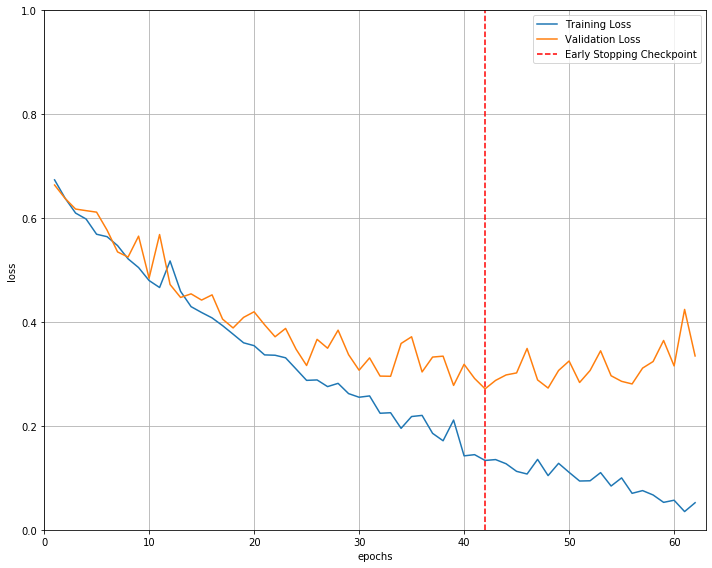

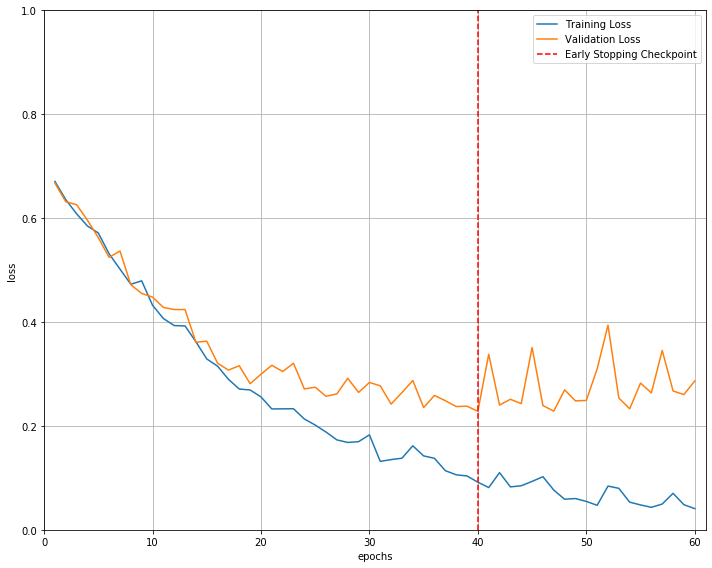

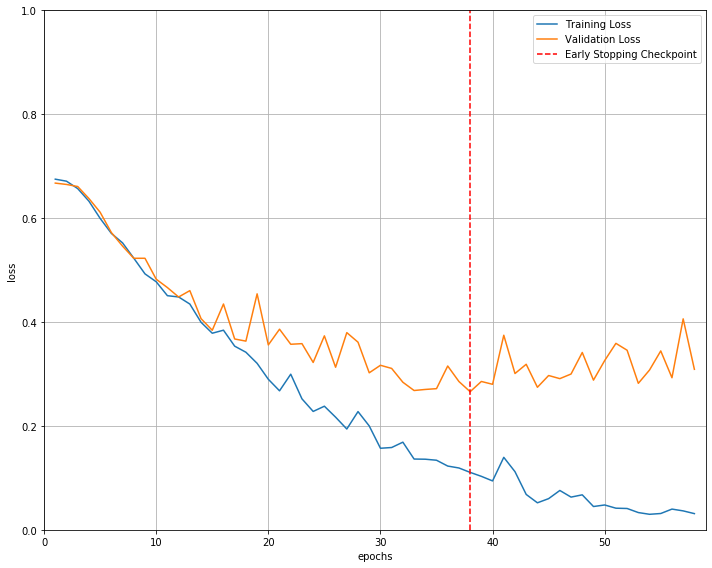

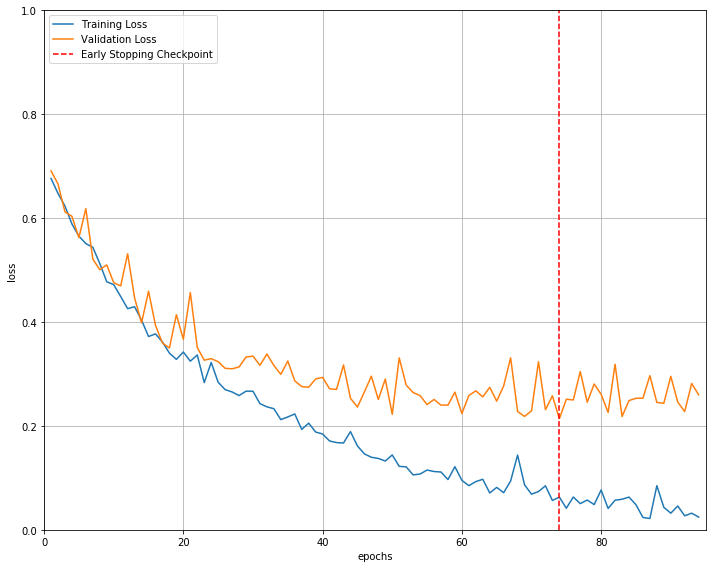

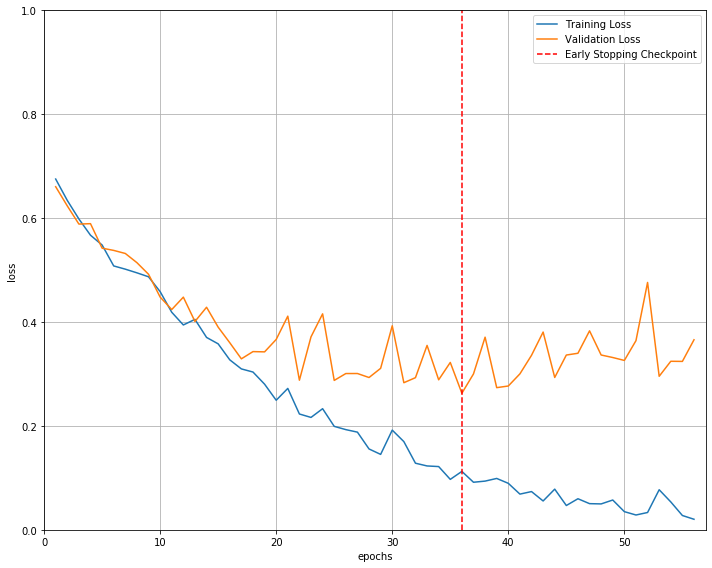

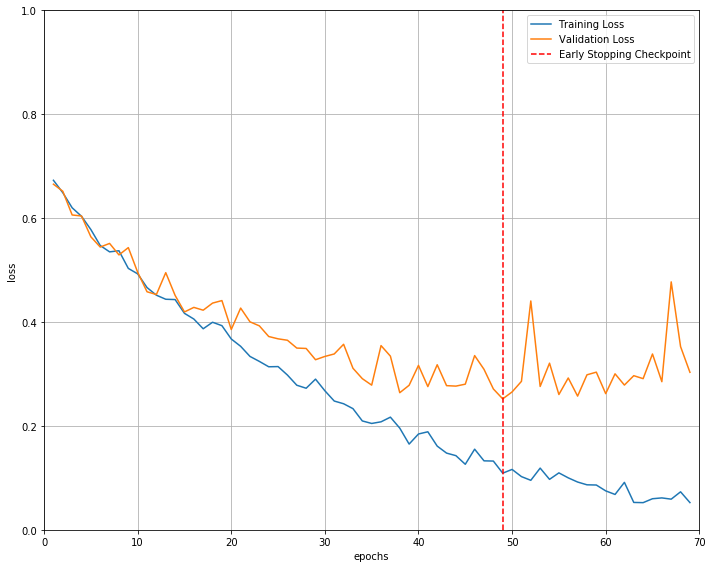

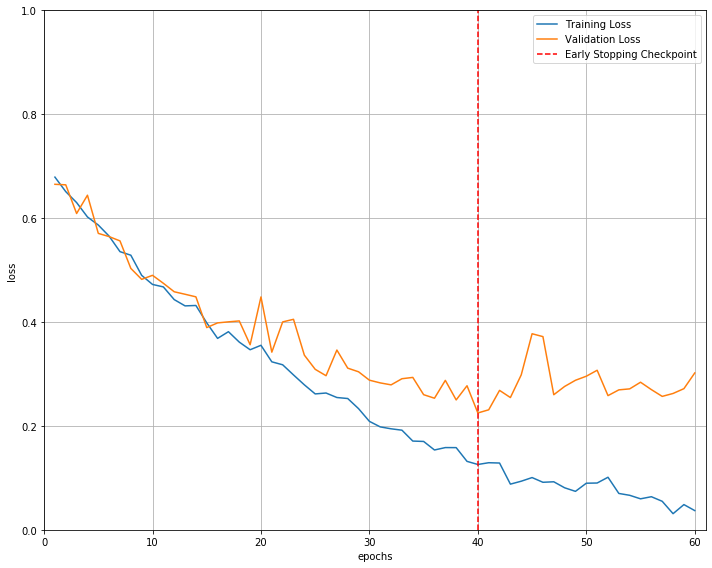

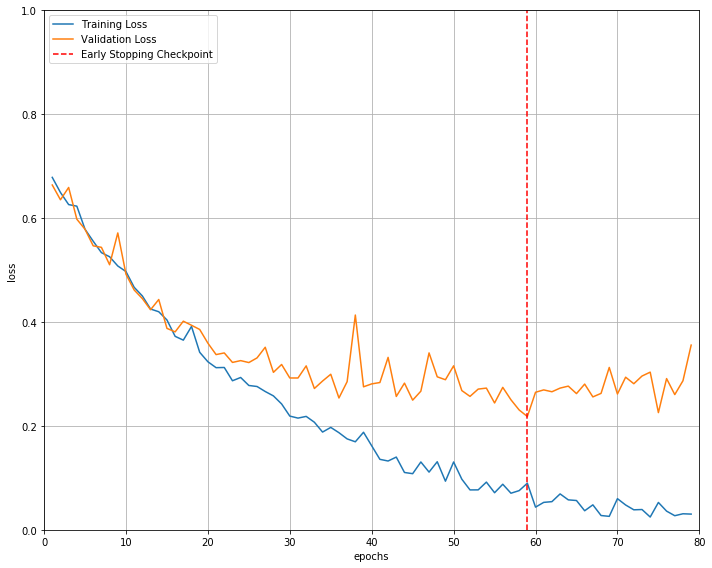

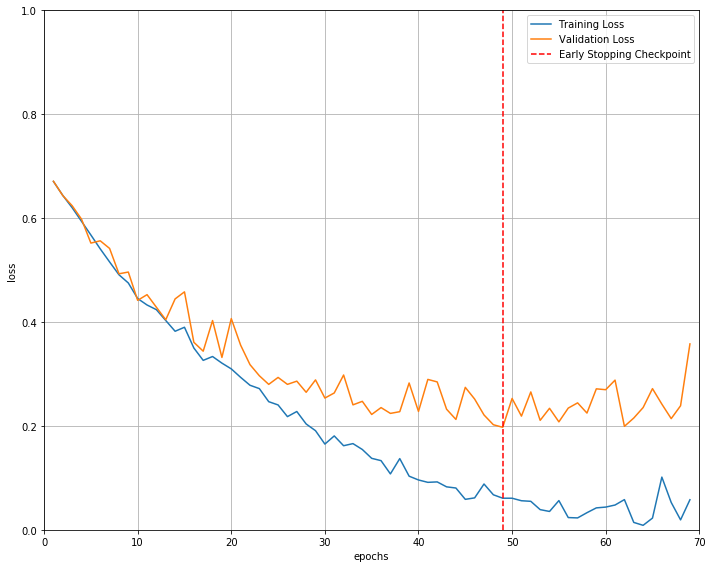

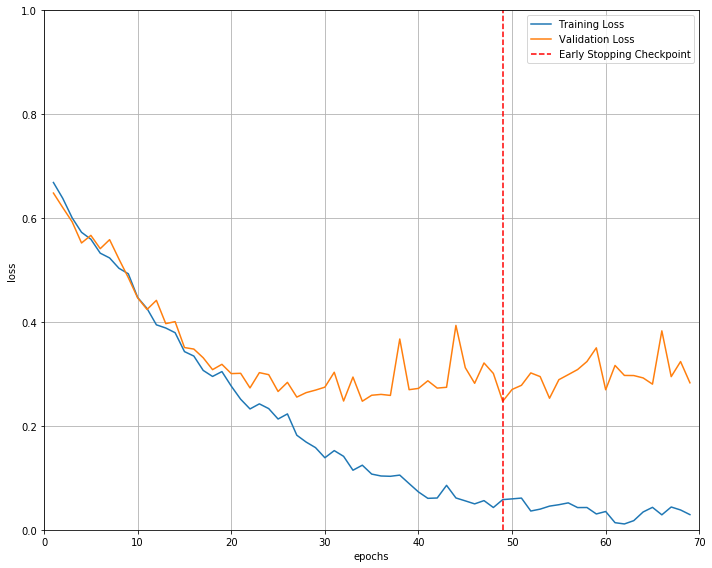

In [24]:
for run in range(runs):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    t_loss = train_loss[run][np.where(train_loss[run] > 0)]
    v_loss = val_loss[run][np.where(val_loss[run] > 0)]
    
    plt.plot(range(1,len(t_loss)+1),t_loss, label='Training Loss')
    plt.plot(range(1,len(v_loss)+1),v_loss,label='Validation Loss')

    # find position of lowest validation loss
    #print(np.where(v_loss == np.min(v_loss))[0][0])
    minposs = np.where(v_loss == np.min(v_loss))[0][0] + 1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 1) # consistent scale
    plt.xlim(0, len(v_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('gintopk/loss_plot_fold{}_run{}.png'.format(fold, run), bbox_inches='tight',dpi=400)

In [11]:
fold=0
run=0
num_class = 2
runs = 10
epochs = 200
train_loss = np.zeros((runs,epochs),dtype=np.float)
val_acc = np.zeros((runs,epochs))
val_loss = np.zeros((runs,epochs))
test_acc_c = np.zeros(runs)
test_loss_c = np.zeros(runs)
test_pred_c = np.zeros(runs)
test_out_c = np.zeros((runs,num_class)) 
groud_truth_c = np.zeros((runs,num_class))
test_acc_p = np.zeros(runs)

model = GINTopK(num_feature=num_feature, num_class=num_class, nhid=nhid).to(device)
model.load_state_dict(torch.load("gintopk/model_gintopk_fold{}_run{}.pth".format(fold, run)))
test_acc_c[run], test_loss_c[run], test_pred_c, test_out_c, ground_truth_c, test_label_c, test_pred_bi_c = test(model,test_surv_loader)
print("** Run: {:03d}, test loss: {:.5f}, test acc: {:.5f}".format(run+1,test_loss_c[run],test_acc_c[run]))
pid_list = list()
test_data = list([None] * len(test_surv_loader))
print(len(test_data))
for i, data in enumerate(test_surv_loader):
    pid_temp = data.pid.cpu().numpy()
    gt = data.y.cpu().numpy()
    test_data[i] = [pid_temp,gt,test_pred_c[i]]
    if not pid_temp in pid_list:
        pid_list.append(pid_temp)
num_test_p = len(pid_list)
test_pred_1 = np.zeros([num_class,num_test_p],dtype=np.int)
pred_p = np.zeros(num_test_p,dtype=np.int)
test_label_p = np.zeros(num_test_p,dtype=np.int)
pid_test = np.array(pid_list)
for j in range(num_test_p):
    pid_1 = pid_list[j]
    k = 0
    for i, data in enumerate(test_surv_loader):
        if data.pid.cpu().numpy()==pid_1:
            if k==0:
                test_label_p[j] = data.y.cpu().numpy()
                k = 1
            test_pred_i = int(test_pred_c[i])
            test_pred_1[test_pred_i,j] = test_pred_1[test_pred_i,j] + 1
    pred_p[j] = np.argmax(test_pred_1[:,j])
#   print('j: {}, pred_p[j]: {}, test_pred_p[j]: {}'.format(j,pred_p[j],test_label_p[j]))
test_acc_p[run] = (pred_p==test_label_p).sum()*1.0/num_test_p
print("Test accuarcy at patient level: {:.2f}".format(test_acc_p[run]*100))
## save data
t1 = time.time()
print("** Model {}, mean test acc (cell): {:.5f}".format(t1,np.mean(test_acc_c)))
sv = 'gintopk/survival_scdiag_gintopk' + '_fold' + str(fold) + '_runs' + str(runs) + '_run' + str(run) + '_epochs' + str(epochs)+'.mat'
sio.savemat(sv,mdict={'val_loss':val_loss,'val_acc':val_acc,'test_loss_c':test_loss_c,'test_acc_c':test_acc_c,'train_loss':train_loss,'test_pred_c':test_pred_c,'test_out_c':test_out_c,'ground_truth_c':ground_truth_c,'test_label_c':test_label_c,'test_pred_bi_c':test_pred_bi_c,'test_acc_p':test_acc_p,'test_pred_p':pred_p,'pid_test':pid_test,'test_data':test_data})

** Run: 001, test loss: 1.56026, test acc: 0.74469
5229
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233


4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
